# 电商案例之营销推荐

## 读入数据

### 数据介绍

本次数据文件共有三个。

orders: 订单数据. 以订单编号作为区分, 用户完成一次购买生成一个订单.

Items_orders: 每一个商品的交易数据.以宝贝类别为区分字段，如果一个订单中包含5种宝贝，此时将会以宝贝为维度，呈现5条数据.每一条数据中，包含宝贝的价格、数量等字段信息。

Items_attribute:商品属性数据.该数据包含宝贝的ID、标题、价格以及玩具类型、适用年龄以及品牌。

### 如何处理数据

这几个表格之间,包含了不同情况情况下产生的数据信息.

首先确定我们的目标是,构建一个用户和物品之间的推荐系数的矩阵.

这里我们采用某用户,对某产品的购买次数,来作为该用户对该产品的喜爱程度.

这个数值越大,则代表用户对该产品评分越高.

因此我们需要统计出每一个用户对每一个产品的购买次数.

### 数据处理流程:

因为有多个表,而这几个表中都包含有我们想要的信息,因此将几个表合并成一个.

如何合并呢? 利用几个表之间相同的字段进行合并.

这和Mysql中的表合并是一样的.

In [1]:
import pandas as pd
import numpy as np
orders = pd.read_csv("emarket/data/orders.csv")
items = pd.read_csv("emarket/data/Items_orders.csv")
itemProps = pd.read_csv("emarket/data/Items_attribute.csv",encoding='gbk')

In [2]:
orders.head()

,订单编号,买家会员名,买家支付宝账号,买家应付货款,买家应付邮费,买家支付积分,总金额,返点积分,买家实际支付金额,买家实际支付积分,...,是否代付,定金排名,修改后的sku,修改后的收货地址,异常信息,天猫卡券抵扣,集分宝抵扣,是否是O2O交易,退款金额,预约门店
0,21407300627014900,1425,yorzikyA6C,58.51,0.0,0,58.51,0,58.51,0,...,否,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
1,24270488269081200,2163,AC870BA5860,15.70,5.0,0,20.70,0,20.70,0,...,否,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
2,21402600386365500,375,AC7574B65A0,7.90,5.0,0,12.90,0,12.90,0,...,否,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
3,21398820349555700,2618,A807C90766A,4.81,5.0,0,9.81,0,9.81,0,...,否,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
4,21446781606162100,2012,A505588565B,23.92,5.0,0,28.92,0,28.92,0,...,否,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN


In [3]:
items.head()

,订单编号,标题,价格,购买数量,外部系统编号,商品属性,套餐信息,备注,订单状态,商家编码
0,21407300627014900,发光玩具批发光纤手指灯闪光夜市热卖货源儿童玩具地摊义乌厂家,0.58,12,WY013-2SZD0426,颜色分类：小号,NaN,NaN,交易成功,WY013-2SZD0426
1,21407300627014900,特价5号AA普通干电池 电动玩具配件 厂家直销批,1.00,20,HT-5H0094,NaN,NaN,NaN,交易成功,HT-5H0094
2,21407300627014900,大号泡泡棒沙滩小铲子工具泡泡枪公园吹泡泡户外亲子游戏玩具热卖,1.20,16,GC018005,NaN,NaN,NaN,交易成功,GC018005
3,21407300627014900,特价正品7号电池儿童电动玩具电源配件 厂家直销1元4节地摊货批发,1.00,10,HT-7H0093,NaN,NaN,NaN,交易成功,HT-7H0093
4,21407300627014900,儿童沙滩玩具水枪 宝宝玩水玩具户外洗澡游泳漂流戏大号水枪批发,6.79,1,GC080003,套餐类型：标准配置;颜色分类：33000蓝色水枪,NaN,NaN,交易成功,GC080003


In [4]:
itemProps.head()

,宝贝ID,标题,价格,玩具类型,适用年龄,品牌
0,537396783238,创意新款回力小车惯性坦克 军事儿童玩具模型地摊货源玩具车批发,8.90,塑胶玩具,"3岁,4岁,5岁,6岁",3
1,36286235128,2017热卖大号仿真惯性挖土机儿童益智礼品创意义乌地摊货玩具批发,3.90,其它玩具,"3岁,4岁,5岁,6岁",3
2,35722000205,创意发光球闪光透明发光水晶弹力球儿童小玩具 夜市地摊货源批发,1.65,其它玩具,"3岁,4岁,5岁,6岁,7岁,8岁,9岁,10岁,11岁,12岁",3
3,550659732532,新款创意六一儿童节礼物音乐投影电动枪夜市地摊货源批发男孩玩具,9.90,其它玩具,"3岁,4岁,5岁,6岁,7岁,8岁,9岁,10岁,11岁,12岁,13岁,14岁",3
4,531877266868,发条玩具批发上链卡通动物青蛙儿童礼物宝宝玩具经典80后益智地摊,1.85,其它玩具,"3岁,4岁",3


## 将数据合并成一张表

观察几个表中的共同字段, 考虑如何进行拼接

In [5]:
# 拼接orders 和 items ,使用它们之间的共同字段 "订单编号"
orders_items = pd.merge(orders,items,on="订单编号")

In [6]:
# 查看拼接好的数据
orders_items.head()

,订单编号,买家会员名,买家支付宝账号,买家应付货款,买家应付邮费,买家支付积分,总金额,返点积分,买家实际支付金额,买家实际支付积分,...,预约门店,标题,价格,购买数量,外部系统编号,商品属性,套餐信息,备注,订单状态_y,商家编码
0,21407300627014900,1425,yorzikyA6C,58.51,0.0,0,58.51,0,58.51,0,...,NaN,发光玩具批发光纤手指灯闪光夜市热卖货源儿童玩具地摊义乌厂家,0.58,12,WY013-2SZD0426,颜色分类：小号,NaN,NaN,交易成功,WY013-2SZD0426
1,21407300627014900,1425,yorzikyA6C,58.51,0.0,0,58.51,0,58.51,0,...,NaN,特价5号AA普通干电池 电动玩具配件 厂家直销批,1.00,20,HT-5H0094,NaN,NaN,NaN,交易成功,HT-5H0094
2,21407300627014900,1425,yorzikyA6C,58.51,0.0,0,58.51,0,58.51,0,...,NaN,大号泡泡棒沙滩小铲子工具泡泡枪公园吹泡泡户外亲子游戏玩具热卖,1.20,16,GC018005,NaN,NaN,NaN,交易成功,GC018005
3,21407300627014900,1425,yorzikyA6C,58.51,0.0,0,58.51,0,58.51,0,...,NaN,特价正品7号电池儿童电动玩具电源配件 厂家直销1元4节地摊货批发,1.00,10,HT-7H0093,NaN,NaN,NaN,交易成功,HT-7H0093
4,21407300627014900,1425,yorzikyA6C,58.51,0.0,0,58.51,0,58.51,0,...,NaN,儿童沙滩玩具水枪 宝宝玩水玩具户外洗澡游泳漂流戏大号水枪批发,6.79,1,GC080003,套餐类型：标准配置;颜色分类：33000蓝色水枪,NaN,NaN,交易成功,GC080003


In [7]:
# 查看拼接后的数据数量
orders_items.shape

(21897, 55)

In [8]:
# 将拼接结果再次和剩下的这个表拼接, 使用共同字段标题
orders_items_props = pd.merge(orders_items,itemProps,on="标题")

In [9]:
orders_items_props.head()

,订单编号,买家会员名,买家支付宝账号,买家应付货款,买家应付邮费,买家支付积分,总金额,返点积分,买家实际支付金额,买家实际支付积分,...,商品属性,套餐信息,备注,订单状态_y,商家编码,宝贝ID,价格_y,玩具类型,适用年龄,品牌
0,21407300627014900,1425,yorzikyA6C,58.51,0.0,0,58.51,0,58.51,0,...,颜色分类：小号,NaN,NaN,交易成功,WY013-2SZD0426,530449665002,0.58,其它玩具,"3岁,4岁,5岁,6岁,7岁,8岁,9岁,10岁",3
1,24043728806509300,882,A5BBABBB0B7,173.10,0.0,0,173.10,0,173.10,0,...,颜色分类：小号,NaN,NaN,交易成功,WY013-2SZD0426,530449665002,0.58,其它玩具,"3岁,4岁,5岁,6岁,7岁,8岁,9岁,10岁",3
2,24043728806509300,882,A5BBABBB0B7,173.10,0.0,0,173.10,0,173.10,0,...,颜色分类：大号,NaN,NaN,交易成功,WY013-1SZD0425,530449665002,0.58,其它玩具,"3岁,4岁,5岁,6岁,7岁,8岁,9岁,10岁",3
3,20885882368182100,279,csongCAA6C,82.73,0.0,0,82.73,0,82.73,0,...,颜色分类：大号,NaN,NaN,交易成功,WY013-1SZD0425,530449665002,0.58,其它玩具,"3岁,4岁,5岁,6岁,7岁,8岁,9岁,10岁",3
4,20885882368182100,279,csongCAA6C,82.73,0.0,0,82.73,0,82.73,0,...,颜色分类：小号,NaN,NaN,交易成功,WY013-2SZD0426,530449665002,0.58,其它玩具,"3岁,4岁,5岁,6岁,7岁,8岁,9岁,10岁",3


## 构建关系矩阵

In [10]:
# 查看拼接后的表格中有多少字段
orders_items_props.columns

Index(['订单编号', '买家会员名', '买家支付宝账号', '买家应付货款', '买家应付邮费', '买家支付积分', '总金额', '返点积分',
       '买家实际支付金额', '买家实际支付积分', '订单状态_x', '买家留言', '收货人姓名', '收货地址', '运送方式',
       '联系电话 ', '联系手机', '订单创建时间', '订单付款时间 ', '宝贝标题 ', '宝贝种类', '物流单号 ', '物流公司',
       '订单备注', '宝贝总数量', '店铺Id', '店铺名称', '订单关闭原因', '卖家服务费', '买家服务费', '发票抬头',
       '是否手机订单', '分阶段订单信息', '特权订金订单id', '是否上传合同照片', '是否上传小票', '是否代付', '定金排名',
       '修改后的sku', '修改后的收货地址', '异常信息', '天猫卡券抵扣', '集分宝抵扣', '是否是O2O交易', '退款金额',
       '预约门店', '标题', '价格_x', '购买数量', '外部系统编号', '商品属性', '套餐信息', '备注', '订单状态_y',
       '商家编码', '宝贝ID', '价格_y', '玩具类型', '适用年龄', '品牌'],
      dtype='object')

In [11]:
# 我们采用表格中的 买家会员名作为行索引,这里买家会员名实际就是买家ID
# 用户物品矩阵的横坐标, 宝贝ID作为纵坐标
result = orders_items_props.loc[:,["买家会员名","宝贝ID"]]

In [12]:
result

,买家会员名,宝贝ID
0,1425,530449665002
1,882,530449665002
2,882,530449665002
3,279,530449665002
4,279,530449665002
...,...,...
19938,2489,544106282196
19939,714,544106282196
19940,131,544106282196
19941,1278,544106282196


In [13]:
#  在后面添加一列购买次数,用户后面统计结果的保存位置 , 先设置为 0
result["购买次数"] = 0

In [14]:
result

,买家会员名,宝贝ID,购买次数
0,1425,530449665002,0
1,882,530449665002,0
2,882,530449665002,0
3,279,530449665002,0
4,279,530449665002,0
...,...,...,...
19938,2489,544106282196,0
19939,714,544106282196,0
19940,131,544106282196,0
19941,1278,544106282196,0


In [15]:
# 使用买家会员名和宝贝ID两个列作为分组的条件进行分组
# 也就是说将数据中买家会员名和宝贝ID相同的统计一下出现的次数, 就是购买次数.
result.groupby(["买家会员名","宝贝ID"]).count()

购买次数
买家会员名 宝贝ID              
0     42577833473      1
1     536728628605     1
      545516801138     1
      547644315780     1
      550735773284     1
...                  ...
3410  35722333869      1
      528109847799     1
      546275765548     1
      546827381933     1
      550977477078     1

[15775 rows x 1 columns]

In [16]:
# 将上面的结果 reset_index 之后 保存
df = result.groupby(["买家会员名","宝贝ID"]).count().reset_index()

In [17]:
df

,买家会员名,宝贝ID,购买次数
0,0,42577833473,1
1,1,536728628605,1
2,1,545516801138,1
3,1,547644315780,1
4,1,550735773284,1
...,...,...,...
15770,3410,35722333869,1
15771,3410,528109847799,1
15772,3410,546275765548,1
15773,3410,546827381933,1


In [18]:
df_pivot = df.pivot(index="买家会员名",columns="宝贝ID",values="购买次数")

In [19]:
df_pivot

宝贝ID,35721027449,35721723963,35722000205,35722333869,35722423659,35750823403,35753244214,35754637865,35797606083,35798309577,...,551081926272,551091071810,551091439907,551135995408,551248890640,551625132527,551675713112,551715398940,552007245556,552028581381
买家会员名,,,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3406,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3407,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3408,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
freq_matrix = df_pivot.fillna(0).values
freq_matrix

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

## 计算物品相似度

In [21]:
from sklearn.metrics.pairwise import cosine_similarity

In [22]:
# freq_matrix.T 将矩阵转置 ,这样计算出来的就是基于物品的相似度了
item_similar_matrix=cosine_similarity(freq_matrix.T)

In [23]:
item_similar_matrix.shape

(269, 269)

## 构建某个用户对某个产品的推荐功能

这里我们采用和课件一样的计算公式, 采用去除均值的计算方法

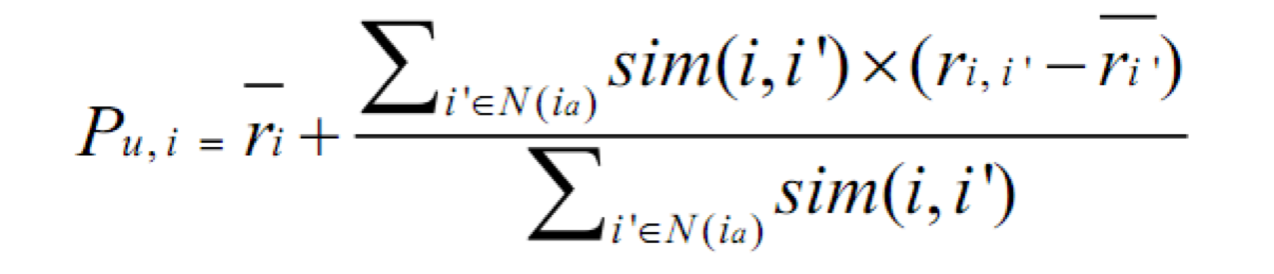

In [40]:
from recommend import cal_recommend_index_by_item

In [27]:
recommend_index= cal_recommend_index_by_item(8, 12, 10 ,
                                        freq_matrix, item_similar_matrix)

In [28]:
recommend_index

0

## 构建预测函数

1. 先构建一个空的矩阵, 用户填充用户和产品之间的推荐指数是
2. 构建的这个矩阵必须是和freq_matrix这个矩阵形状相同
3. 写一个两层循环, 分别对矩阵中的值进行运算, 采用刚才写好的cal_recommend_index函数进行计算其中的值.
4. 前提条件: 如果原来freq_matrix中的值已经有了,则不需要计算,如果值为0,则计算这个值,并填充到构建的空矩阵当中去

In [38]:
def cal_recommend_index_matrix(freq_matrix ,item_similar_matrix):
    """函数功能: 传入用户评分矩阵, 计算并返回用户对所有产品的推荐矩阵
    参数:
    freq_matrix: 用户评分矩阵
    返回值: 推荐系数矩阵"""
    predict_matrix = np.zeros_like(freq_matrix)

    # 写一个两层循环, 分别对predict_matrix 矩阵中的每一个位置的值进行遍历
    # predict_matrix.shape[0] 代表用户个数 , range()生成一个线性序列和这个长度相同
    for user_id in range(predict_matrix.shape[0]):
        # 对每行中的每一个值进行遍历
        for item_id in range(predict_matrix.shape[1]):
            # 首先判断原来这个用户有没有对这个产品评分过,如果有不需要计算,如果没有 值为0,则进行计算
            if freq_matrix[user_id,item_id ] == 0:
                # 如果为0 计算推荐指数,
                recommend_index= cal_recommend_index_by_item(10, user_id, item_id ,
                                        freq_matrix, item_similar_matrix)
                # 算出来之后, 把这个数值保存到矩阵中去
                predict_matrix[user_id , item_id] = recommend_index
    return predict_matrix

In [43]:
import recommend
import imp
imp.reload(recommend)
from recommend import cal_recommend_index_by_items

In [44]:
# 调用上面的函数计算推荐系数矩阵
predict_matrix = cal_recommend_index_matrix_by_items(freq_matrix,item_similar_matrix,k=10)
predict_matrix

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.89102564, 0.        , 1.4586727 , ..., 0.        , 0.        ,
        0.        ],
       [0.89102564, 0.        , 1.4586727 , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.75969251, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

## 构建最终的推荐功能

1. 首先把上面的矩阵转换成DataFrame,方便操作
2. 现在的推荐矩阵不太方便操作,我们把数据转换回最初的那种格式
```
recom_df = recom_df.stack().reset_index()
```
3. 现在我们需要根据每一个用户ID,提取推荐指数最大的两个产品
4. 所以我们需要对数据进行分组, 根据用户ID进行分组.
5. 如何提取出最大的两个数据呢? 默认没有这样功能, 所以我们自己构建一个函数,然后使用分组中的apply功能 , 应用这个聚合函数, 得到最终推荐结果.
6. 清理数据中的无效信息

In [45]:
# 定义函数功能, 参数n代表要提取几个东西
# 第一个参数分组结果
def get_topn(group, n):
    # group 就代表了每一组数据
    # 计算出每一组数据中的最大的两个数据的id 和指数
    # 首先对每组数据进行排序, 排序后切片出前两个最大的值
    r = group.sort_values(by='推荐指数', ascending=False)[:n]
    return r

In [46]:
def get_recom(predict_matrix ,n=5):
    # 把这个推荐矩阵转换成DataFrame, 索引值使用之前的那个df_pivot的索引值
    recom_df = pd.DataFrame(predict_matrix ,index=df_pivot.index , 
             columns= df_pivot.columns)
    # 对多重索引的Series进行 reset_index , 就会把索引和列都变成DataFrame里面的数据
    recom_df_2 = recom_df.stack().reset_index()
    # 把上面的列名0 改成 推荐指数
    recom_df_2.rename(columns={0:"推荐指数"},inplace=True)
    
    # 对数据进行分组
    grouped = recom_df_2.groupby("买家会员名")
    # 应用上面的统计函数, 统计出前k个推荐物品
    topn = grouped.apply(get_topn,n=n)
#     print(topn)
    # 这里都是和之前的代码一样的操作
    topn = topn.drop(["买家会员名"],axis=1)
    
    topn.index = topn.index.droplevel(1)
   
    topn.reset_index(inplace=True)
#     print(topn)
    return topn


In [47]:
user_recom = get_recom(predict_matrix,5)
user_recom

,买家会员名,宝贝ID,推荐指数
0,0,544016559367,2.158102
1,0,537396783238,1.945519
2,0,544115359956,1.830060
3,0,546275765548,0.866250
4,0,550715341924,0.783523
...,...,...,...
16585,3410,549736062191,2.005714
16586,3410,36286235128,1.982439
16587,3410,549378588703,1.756588
16588,3410,36353085367,1.599292
